In [2]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns


import re
import string
from collections import Counter
import nltk

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set(context='notebook', style='whitegrid') 

# Data Overview

In [3]:
df= pd.read_csv("/users/meghabista/taylorswiftlyrics/TaylorSwiftLyricsFeatureSet.csv")
df=df.rename(columns={"Album":"track_album","Artist":"track_artist","Track":"track_title","TrackURI":"track_uri" , "TrackID":"track_id" ,"Lyrics":"track_lyric"})

In [4]:
df.head()

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_uri,track_id,track_lyric,genres
0,Taylor Swift,Taylor Swift,Tim McGraw,0.580,0.491,0,-6.462,1,0.0251,0.575,0.0,0.1210,0.425,76.009,232107,4,spotify:track:0Om9WAB5RS09L80DyOfTNa,0Om9WAB5RS09L80DyOfTNa,He said the way my blue eyes shined\nPut those...,Country
1,Taylor Swift,Taylor Swift,Picture To Burn,0.658,0.877,7,-2.098,1,0.0323,0.173,0.0,0.0962,0.821,105.586,173067,4,spotify:track:32mVHdy0bi1XKgr0ajsBlG,32mVHdy0bi1XKgr0ajsBlG,"State the obvious, I didn't get my perfect fan...",Country Rock
2,Taylor Swift,Taylor Swift,Teardrops On My Guitar,0.621,0.417,10,-6.941,1,0.0231,0.288,0.0,0.1190,0.289,99.953,203040,4,spotify:track:7zMcNqs55Mxer82bvZFkpg,7zMcNqs55Mxer82bvZFkpg,Drew looks at me\nI fake a smile so he won't s...,Country Pop
3,Taylor Swift,Taylor Swift,A Place In This World,0.576,0.777,9,-2.881,1,0.0324,0.051,0.0,0.3200,0.428,115.028,199200,4,spotify:track:73OX8GdpOeGzKC6OvGSbsv,73OX8GdpOeGzKC6OvGSbsv,"I don't know what I want, so don't ask me\nCau...",Country Pop
4,Taylor Swift,Taylor Swift,Cold as You,0.418,0.482,5,-5.769,1,0.0266,0.217,0.0,0.1230,0.261,175.558,239013,4,spotify:track:7an1exwMnfYRcdVQm0yDev,7an1exwMnfYRcdVQm0yDev,You have a way of coming easily to me\nAnd whe...,Country


In [5]:
df.tail()

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_uri,track_id,track_lyric,genres
106,Lover,Taylor Swift,Miss Americana & the Heartbreak Prince,0.662,0.747,11,-6.926,0,0.0736,0.02800,0.006150,0.1380,0.487,150.088,234147,4,spotify:track:214nt20w5wOxJnY462klLw,214nt20w5wOxJnY462klLw,"You know I adore you, I'm crazier for you\nTha...",NaN
107,Lover,Taylor Swift,Paper Rings,0.811,0.719,9,-6.553,1,0.0497,0.01290,0.000014,0.0742,0.865,103.979,222400,4,spotify:track:4y5bvROuBDPr5fuwXbIBZR,4y5bvROuBDPr5fuwXbIBZR,The moon is high\nLike your friends were the n...,NaN
108,Lover,Taylor Swift,Soon You'll Get Better (feat. Dixie Chicks),0.433,0.182,0,-12.566,1,0.0641,0.90700,0.000000,0.1230,0.421,207.476,201587,4,spotify:track:4AYtqFyFbX0Xkc2wtcygTr,4AYtqFyFbX0Xkc2wtcygTr,The buttons of my coat were tangled in my hair...,NaN
109,Lover,Taylor Swift,The Archer,0.292,0.574,0,-9.375,1,0.0401,0.12000,0.005690,0.0663,0.166,124.344,211240,4,spotify:track:3pHkh7d0lzM2AldUtz2x37,3pHkh7d0lzM2AldUtz2x37,Combat\nI'm ready for combat\nI say I don't wa...,Dream Pop
110,Lover,Taylor Swift,You Need to Calm Down,0.771,0.671,2,-5.617,1,0.0553,0.00929,0.000000,0.0637,0.714,85.026,171360,4,spotify:track:6RRNNciQGZEXnqk8SQ9yv5,6RRNNciQGZEXnqk8SQ9yv5,You are somebody that I don't know\nBut you're...,Pop


In [6]:
df['year_released'] = df['track_album']
df['year_released'] = df['year_released'].replace(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989',
       'reputation', 'Lover'],[2006,2008,2010,2012,2014,2017,2019])


In [7]:
df['world_sales_USD'] = df['track_album'].replace(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989',
       'reputation', 'Lover'],[7000000,12000000,5500000,6000000,10500000,5000000,4000000])

In [8]:

df.describe(include='all')

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,track_uri,track_id,track_lyric,genres,year_released,world_sales_USD
count,111,111,111,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111,111,111,95,111.000000,1.110000e+02
unique,7,5,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,111,111,111,16,NaN,NaN
top,Red,Taylor Swift,Tim McGraw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,spotify:track:0Om9WAB5RS09L80DyOfTNa,0Om9WAB5RS09L80DyOfTNa,He said the way my blue eyes shined\nPut those...,Country Pop,NaN,NaN
freq,19,107,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,1,20,NaN,NaN
mean,NaN,NaN,NaN,0.613595,0.616441,4.639640,-6.453261,0.882883,0.073693,0.197342,...,0.423593,122.176027,231977.243243,3.963964,NaN,NaN,NaN,NaN,2012.504505,6.959459e+06
std,NaN,NaN,NaN,0.112205,0.176523,3.257977,2.266960,0.323018,0.132049,0.253976,...,0.198856,31.460427,45882.035346,0.328299,NaN,NaN,NaN,NaN,4.289255,2.681702e+06
min,NaN,NaN,NaN,0.292000,0.151000,0.000000,-12.864000,0.000000,0.023100,0.000197,...,0.049900,68.534000,51920.000000,1.000000,NaN,NaN,NaN,NaN,2006.000000,4.000000e+06
25%,NaN,NaN,NaN,0.552500,0.484000,2.000000,-7.499500,1.000000,0.029500,0.022950,...,0.264500,96.005000,207813.500000,4.000000,NaN,NaN,NaN,NaN,2010.000000,5.000000e+06
50%,NaN,NaN,NaN,0.612000,0.651000,5.000000,-6.237000,1.000000,0.037200,0.082600,...,0.416000,118.984000,231000.000000,4.000000,NaN,NaN,NaN,NaN,2012.000000,6.000000e+06
75%,NaN,NaN,NaN,0.691000,0.753000,7.000000,-4.947000,1.000000,0.063500,0.238500,...,0.558000,146.015000,245080.000000,4.000000,NaN,NaN,NaN,NaN,2017.000000,1.050000e+07


In [9]:
df['genres'].unique()

array(['Country', 'Country Rock', 'Country Pop', nan,
       'Contemporary Country', 'Pop Rock', 'Folk Pop', 'Blue grass',
       'Pop Punk', 'Soft Rock', 'Alternative Rock', 'Pop', 'Electropop',
       'Synth Pop', 'Dance Pop', 'Dream Pop', 'R&B'], dtype=object)

In [10]:
df.track_lyric[1]

"State the obvious, I didn't get my perfect fantasy\nI realize you love yourself more than you could ever love me\nSo go and tell your friends that I'm obsessive and crazy\nThat's fine, I'll tell mine that you're gay\nBy the way\nI hate that stupid old pickup truck\nYou never let me drive\nYou're a redneck heartbreak\nWho's really bad at lying\nSo watch me strike a match\nOn all my wasted time\nAs far as I'm concerned you're\nJust another picture to burn\nThere's no time for tears\nI'm just sitting here planning my revenge\nThere's nothing stopping me\nFrom going out with all of your best friends\nAnd if you come around saying sorry to me\nMy daddy's gonna show you how sorry you'll be\nI hate that stupid old pickup truck\nYou never let me drive\nYou're a redneck heartbreak\nWho's really bad at lying\nSo watch me strike a match\nOn all my wasted time\nAs far as I'm concerned you're\nJust another picture to burn\nAnd if you're missing me\nYou'd better keep it to yourself\n'Cause coming b

In [11]:
df.track_lyric[5]

"I didn't know what I would find\nWhen I went looking for a reason, I know\nI didn't read between the lines\nAnd, baby, I've got nowhere to go\nI tried to take the road less traveled by\nBut nothing seems to work the first few times\nAm I right?\nSo how can I ever try to be better?\nNobody ever lets me in\nI can still see you, this ain't the best view\nOn the outside looking in\nI've been a lot of lonely places\nI've never been on the outside\nYou saw me there, but never knew\nI would give it all up to be\nA part of this, a part of you\nAnd now it's all too late so you see\nYou could've helped if you had wanted to\nBut no one notices until it's too\nLate to do anything\nSo how can I ever try to be better?\nNobody ever lets me in\nI can still see you, this ain't the best view\nOn the outside looking in\nI've been a lot of lonely places\nI've never been on the outside\nSo how can I ever try to be better?\nNobody ever lets me in\nI can still see you, this ain't the best view\nOn the outsi

# Cleaning for NLP

In [12]:
remove_n = lambda x: re.sub('\n',' ',x)
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['track_lyric'] = df.track_lyric.map(remove_n).map(punc_lower).map(alphanumeric)

In [13]:
df.track_lyric[50]

'i bet this time of night you re still up i bet you re tired from a long hard week i bet you re sitting in your chair by the window looking out at the city and i bet sometimes you wonder about me and i just want to tell you it takes everything in me not to call you and i wish i could run to you and i hope you know that everytime i don t i almost do  i almost do i bet you think i either moved on or hate you ‘cause each time you reach out there s no reply i bet it never  ever occurred to you that i can t say hello to you and risk another goodbye and i just want to tell you it takes everything in me not to call you and i wish i could run to you and i hope you know that everytime i don t i almost do  i almost do oh  we made quite a mess  babe it s probably better off this way and i confess  baby in my dreams you re touching my face and asking me if i d want to try again with you and i almost do and i just want to tell you it takes everything in me not to call you and i wish i could run to 

In [14]:
song_titles = df['track_title'].values

In [16]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.1,max_df=0.7)

doc_matrix = vectorizer.fit_transform(df.track_lyric)

doc_matrix = pd.DataFrame(doc_matrix.toarray(), columns=vectorizer.get_feature_names())

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
doc_matrix.head()

,ain,away,baby,bad,beautiful,best,better,blue,break,car,...,walk,wanna,want,wanted,way,won,world,wrong,yeah,years
0,0,0,0,0,0,0,0,5,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,0,2,5,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,2,0,1,0,1,3,...,0,0,1,0,0,2,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,3,3,1,0
4,0,4,0,0,0,1,0,0,0,0,...,2,0,1,1,1,0,0,0,0,0


In [18]:
vectorizer_bi = CountVectorizer(ngram_range=(1,2),binary=True,stop_words='english',min_df=0.1,max_df=0.7)

doc_matrix_bi = vectorizer_bi.fit_transform(df.track_lyric)

bi_doc_matrix = pd.DataFrame(doc_matrix_bi.toarray(), columns=vectorizer_bi.get_feature_names())

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
bi_doc_matrix.head()

,ain,away,baby,bad,beautiful,best,better,blue,break,car,...,walk,wanna,want,wanted,way,won,world,wrong,yeah,years
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,1,0,1,1,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,1,1,0
4,0,1,0,0,0,1,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0


# EDA

In [20]:
XtoPredict = df.loc[df['genres'].isnull(),:].drop(columns=['track_uri','track_id']).reset_index(drop=True)
FeatureSet = df.loc[df['genres'].notnull(),:].drop(columns=['track_uri','track_id']).reset_index(drop=True)
FeatureSet.head()

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_lyric,genres,year_released,world_sales_USD
0,Taylor Swift,Taylor Swift,Tim McGraw,0.580,0.491,0,-6.462,1,0.0251,0.575,0.0,0.1210,0.425,76.009,232107,4,he said the way my blue eyes shined put those ...,Country,2006,7000000
1,Taylor Swift,Taylor Swift,Picture To Burn,0.658,0.877,7,-2.098,1,0.0323,0.173,0.0,0.0962,0.821,105.586,173067,4,state the obvious i didn t get my perfect fan...,Country Rock,2006,7000000
2,Taylor Swift,Taylor Swift,Teardrops On My Guitar,0.621,0.417,10,-6.941,1,0.0231,0.288,0.0,0.1190,0.289,99.953,203040,4,drew looks at me i fake a smile so he won t se...,Country Pop,2006,7000000
3,Taylor Swift,Taylor Swift,A Place In This World,0.576,0.777,9,-2.881,1,0.0324,0.051,0.0,0.3200,0.428,115.028,199200,4,i don t know what i want so don t ask me caus...,Country Pop,2006,7000000
4,Taylor Swift,Taylor Swift,Cold as You,0.418,0.482,5,-5.769,1,0.0266,0.217,0.0,0.1230,0.261,175.558,239013,4,you have a way of coming easily to me and when...,Country,2006,7000000


In [21]:
print(len(FeatureSet.genres.unique()))

country = ['Country Pop','Country','Folk Pop','Blue grass','Contemporary Country']
pop = ['Pop','Electropop','Synth Pop','Dance Pop','Dream Pop']
rock = ['Pop Rock','Pop Punk','Alternative Rock','Soft Rock','R&B','Country Rock',]

print(len(rock)+len(country)+len(pop))

16
16


In [22]:
genre_broad = []
for index,i in enumerate(FeatureSet.genres):
    if i in country:
        genre_broad.append('country')
    
    if i in rock:
        genre_broad.append('rock')
    
    if i in pop:
        genre_broad.append('pop')
        
FeatureSet['genre_broad']=genre_broad

<AxesSubplot: xlabel='genre_broad'>

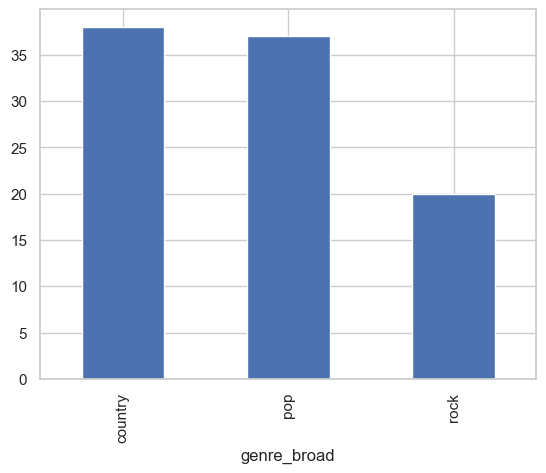

In [23]:
FeatureSet.groupby('genre_broad').count()['track_title'].plot.bar()

# Checking for outliers

Text(0.5, 1.0, 'Duration')

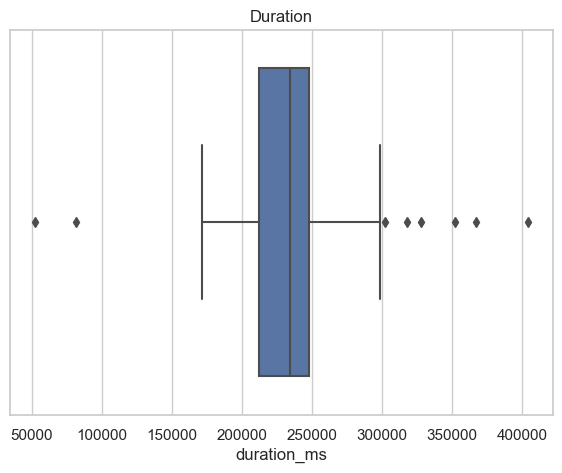

In [24]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='duration_ms',data=FeatureSet)
plt.title("Duration")

# Correlation between features 

/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_24793/678234293.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU


<AxesSubplot: >

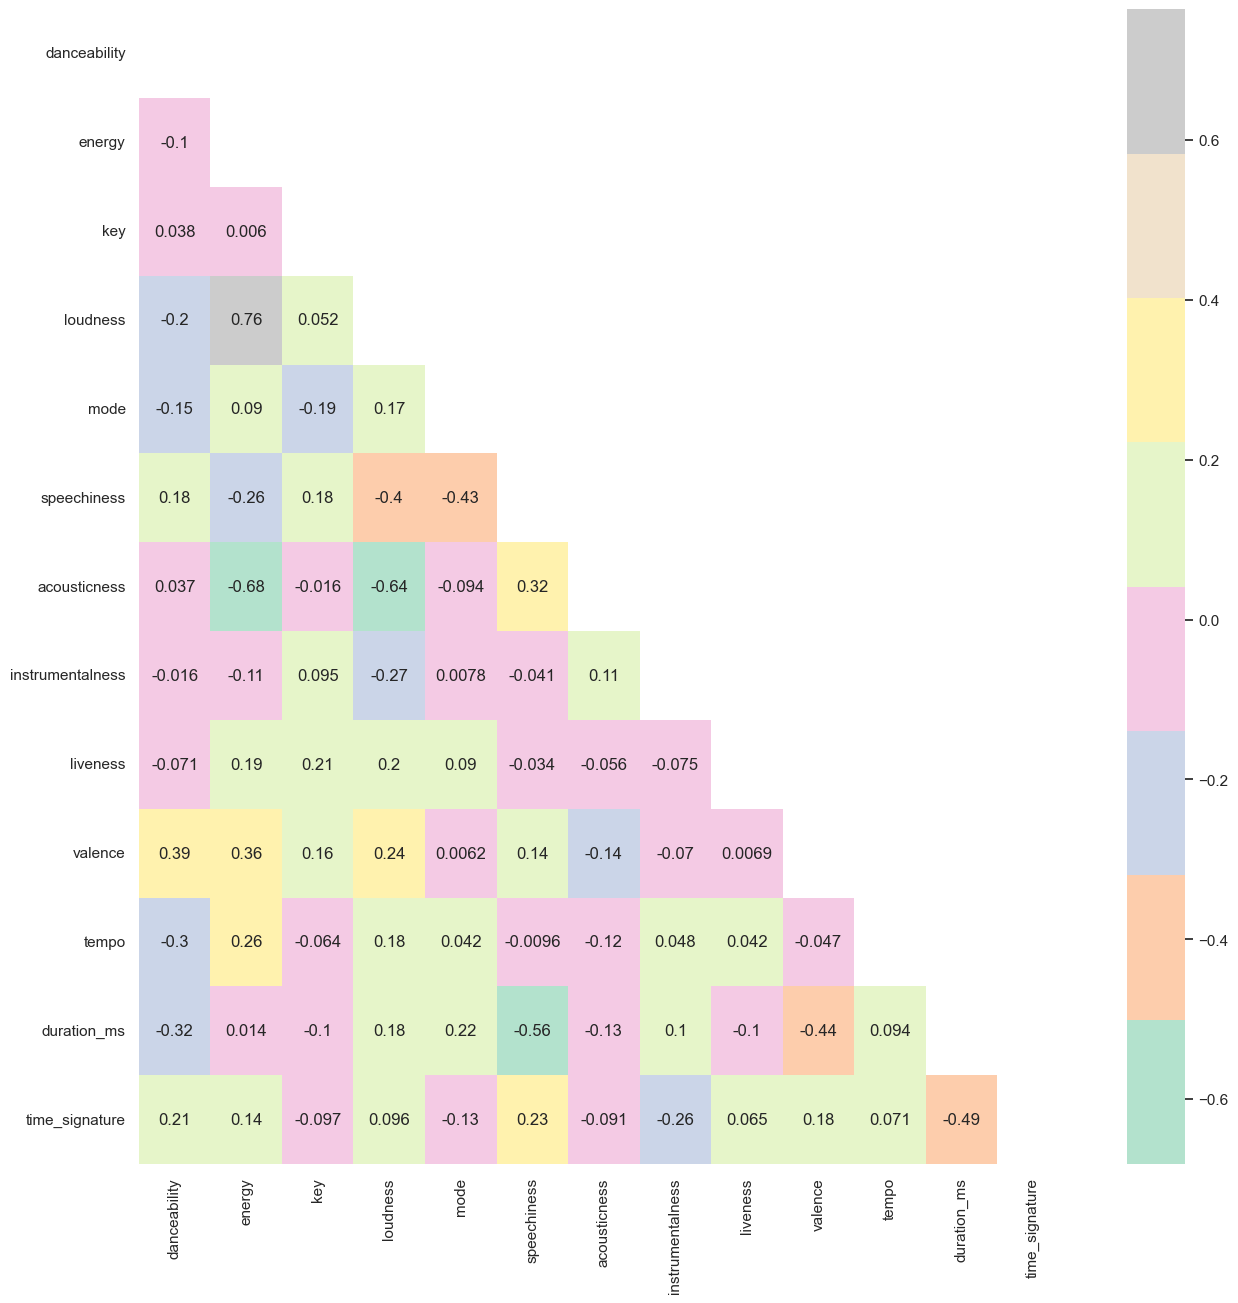

In [25]:
fig = plt.figure(figsize=(15,15))

corr =df.loc[:,'danceability':'time_signature'].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

sns.heatmap(corr,annot=True,mask=mask,cmap='Pastel2')

Loudness and energy are the most correlated

# Correlation betweeen genres 

/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_24793/705552190.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_rel= FeatureSet.groupby('genres').median().loc[:,'danceability':'time_signature']
/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_24793/705552190.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU


<AxesSubplot: xlabel='genres', ylabel='genres'>

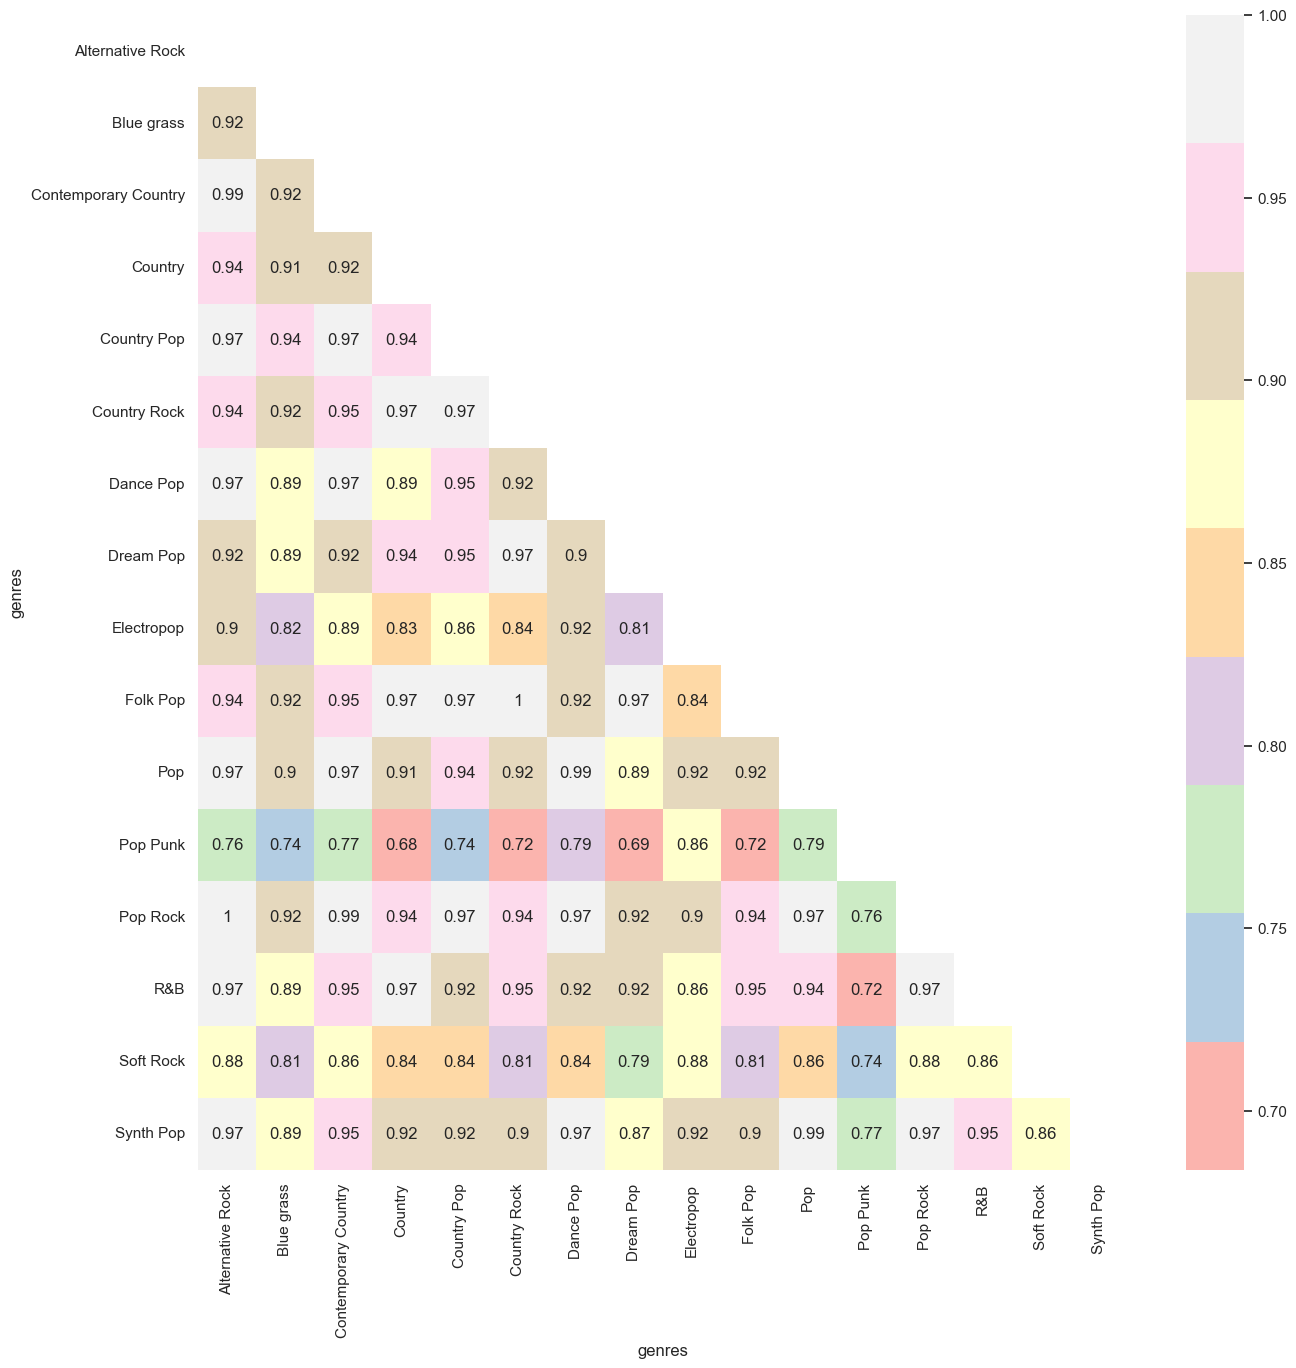

In [26]:
genre_rel= FeatureSet.groupby('genres').median().loc[:,'danceability':'time_signature']

corr=genre_rel.transpose().corr('kendall')
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

fig = plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True,mask=mask,cmap='Pastel1')

/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_92520/3808509567.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_rel= FeatureSet.groupby('genre_broad').median().loc[:,'danceability':'time_signature']


<AxesSubplot: xlabel='genre_broad', ylabel='genre_broad'>

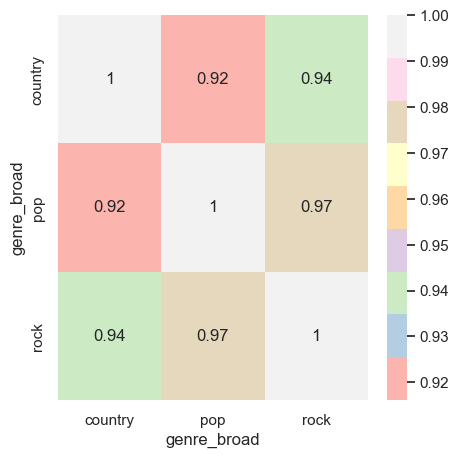

In [31]:
genre_rel= FeatureSet.groupby('genre_broad').median().loc[:,'danceability':'time_signature']

corr=genre_rel.transpose().corr('kendall')
#mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

fig = plt.figure(figsize=(5,5))
sns.heatmap(corr,annot=True,cmap='Pastel1')

# Distribution plots for all audio features

/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_24793/3716382952.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.danceability)
/var/folders/ts/k0h7z41511j57zk5hp5gdf9m0000gn/T/ipykernel_24793/3716382952.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.energy)
/var/folders

<AxesSubplot: xlabel='tempo', ylabel='Density'>

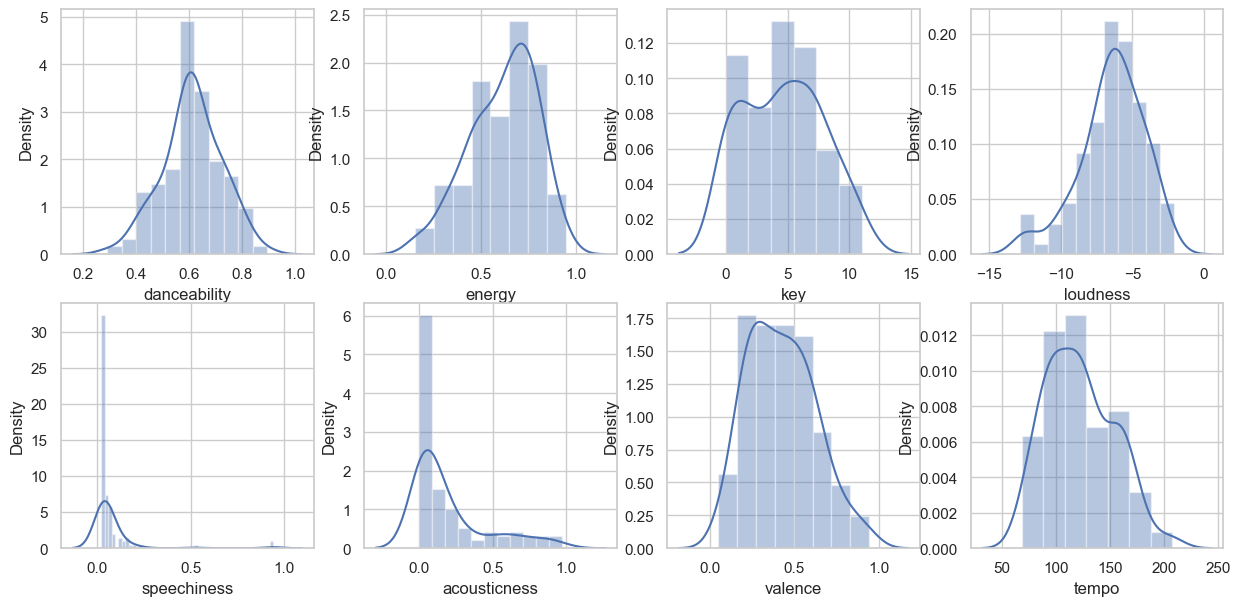

In [27]:
fig = plt.figure(figsize=(15,7))

fig.add_subplot(2,4,1)
sns.distplot(df.danceability)

fig.add_subplot(2,4,2)
sns.distplot(df.energy)

fig.add_subplot(2,4,3)
sns.distplot(df.key)

fig.add_subplot(2,4,4)
sns.distplot(df.loudness)

fig.add_subplot(2,4,5)
sns.distplot(df.speechiness)

fig.add_subplot(2,4,6)
sns.distplot(df.acousticness)

fig.add_subplot(2,4,7)
sns.distplot(df.valence)

fig.add_subplot(2,4,8)
sns.distplot(df.tempo)

# Screeplot

Text(0.5, 1.0, 'Scree plot')

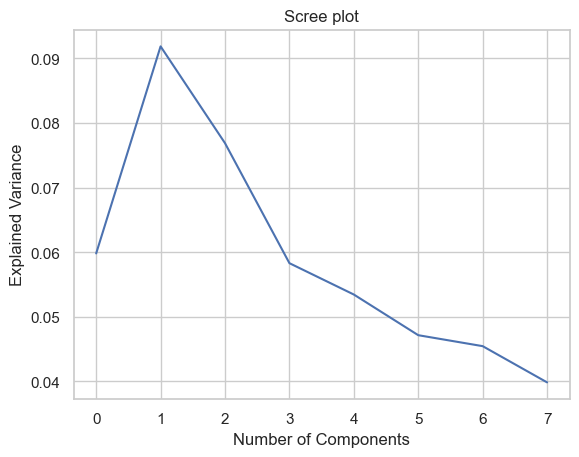

In [28]:
lsascree = TruncatedSVD(8)
lsascree.fit(doc_matrix)
lsa_features = lsascree.transform(doc_matrix)
plt.plot(lsascree.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree plot')

Text(0.5, 1.0, 'Scree plot')

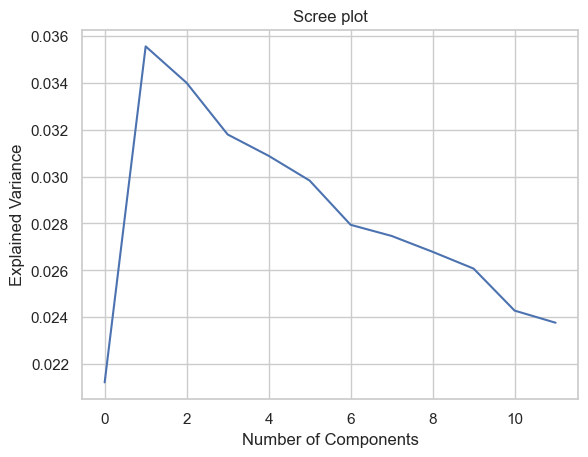

In [29]:
lsascree = TruncatedSVD(12)
lsascree.fit(doc_matrix_bi)
lsa_features = lsascree.transform(doc_matrix_bi)
plt.plot(lsascree.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree plot')

# Latent Semantic Analysis

* popular, dimensionality-reduction techniques that follows the same method as Singular Value Decomposition.
* LSA  reformulates text data in terms of r latent features, where r is less than m, the number of terms in the data.

In [30]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [31]:
def lsa_function(num_components, doc_text_matrix, vectorizer):
    lsa = TruncatedSVD(num_components)
    doc_topic = lsa.fit_transform(doc_text_matrix)
    print('Explained Variance:',lsa.explained_variance_ratio_)
    
    index = []
    for i in range(num_components):
        index.append(i)
    topic_word = pd.DataFrame(lsa.components_.round(3),
             index = index,
             columns = vectorizer.get_feature_names())
    
    print(display_topics(lsa, vectorizer.get_feature_names(), 15))
    
    return topic_word

In [32]:
lsa_function(3,doc_matrix,vectorizer)

Explained Variance: [0.05980756 0.09185642 0.07687545]

Topic  0
oh, don, just, ll, got, ve, ooh, time, love, look, cause, say, baby, want, wanna

Topic  1
ooh, getting, wanna, friends, look, waiting, end, miss, yeah, say, remember, night, heart, change, day

Topic  2
got, ve, wanna, don, look, love, baby, bad, cause, come, end, did, think, ll, good
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ain,away,baby,bad,beautiful,best,better,blue,break,car,...,walk,wanna,want,wanted,way,won,world,wrong,yeah,years
0,0.038,0.055,0.159,0.106,0.030,0.038,0.061,0.017,0.055,0.049,...,0.018,0.131,0.142,0.017,0.062,0.035,0.033,0.025,0.110,0.009
1,-0.010,0.006,-0.017,-0.000,-0.011,-0.013,-0.022,-0.006,0.000,-0.049,...,-0.005,0.119,-0.049,-0.010,-0.013,-0.012,-0.006,-0.013,0.033,-0.004
2,0.002,0.033,0.164,0.160,0.009,-0.004,0.009,0.003,0.013,-0.109,...,-0.003,0.197,-0.016,-0.011,0.058,0.012,0.010,-0.007,-0.031,-0.001


# Top word in each song

In [33]:
word_doc = doc_matrix.transpose()

In [34]:
top_songs = {}
for song in word_doc.columns:
    top = word_doc[song].sort_values(ascending=False).head(30)
    top_songs[song] = list(zip(top.index,top.values))

In [35]:
for song, top_words in top_songs.items():
    print(song)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')


0
think, night, blue, little, said, old, head, long, dress, eyes, time, way, ll, street
---
1
really, time, just, bad, old, drive, let, sorry, baby, cause, love, friends, ll, tell
---
2
car, don, got, won, ll, cause, smile, beautiful, thing, love, tell, time, fall, home
---
3
oh, just, girl, ll, trying, don, life, wrong, world, place, got, tell, old, heart
---
4
away, day, thinking, oh, ve, cold, walk, say, just, cause, feel, honey, need, did
---
5
ve, looking, ain, better, try, best, didn, saw, wanted, right, knew, got, baby, times
---
6
baby, smile, coming, don, hold, tell, cause, high, oh, walk, face, thinking, rain, looking
---
7
beautiful, oh, don, stay, door, love, life, gonna, little, really, way, ll, day, home
---
8
ve, said, gone, baby, mind, thought, did, home, say, let, wrong, things, looking, just
---
9
said, oh, ll, did, time, eyes, lights, town, love, years, got, fall, need, look
---
10
got, don, didn, way, play, cause, said, phone, door, home, kiss, wrong, car, thinking


# Add stop words

In [36]:
doc_matrix.shape

(111, 122)

In [37]:
words = []
for song in word_doc.columns:
    top = [word for (word,count) in top_songs[song]]
    for t in top:
        words.append(t)

In [44]:
Counter(words).most_common()

[('oh', 76),
 ('just', 76),
 ('right', 73),
 ('don', 67),
 ('remember', 66),
 ('really', 65),
 ('cause', 64),
 ('rain', 64),
 ('play', 60),
 ('say', 60),
 ('love', 58),
 ('place', 55),
 ('time', 53),
 ('night', 52),
 ('ll', 52),
 ('make', 50),
 ('room', 49),
 ('got', 49),
 ('ve', 48),
 ('phone', 46),
 ('mind', 43),
 ('said', 41),
 ('old', 38),
 ('people', 38),
 ('need', 38),
 ('away', 38),
 ('think', 37),
 ('new', 37),
 ('ooh', 37),
 ('baby', 37),
 ('want', 37),
 ('let', 36),
 ('way', 35),
 ('loved', 35),
 ('tell', 34),
 ('yeah', 34),
 ('eyes', 33),
 ('run', 32),
 ('met', 31),
 ('home', 29),
 ('look', 29),
 ('miss', 27),
 ('come', 27),
 ('ain', 27),
 ('gonna', 25),
 ('little', 24),
 ('long', 24),
 ('didn', 24),
 ('face', 24),
 ('thing', 23),
 ('lights', 23),
 ('feel', 22),
 ('things', 22),
 ('good', 22),
 ('wanna', 22),
 ('better', 21),
 ('life', 21),
 ('knew', 21),
 ('lost', 21),
 ('saw', 20),
 ('gone', 20),
 ('smile', 20),
 ('girl', 20),
 ('town', 20),
 ('took', 20),
 ('best', 19),
 

In [38]:
all_stops = ['just','don','gonna','cause','ll','ve','got','oh','eh','aah','want','way','away','ooh','wanna']

In [39]:
stop_words = text.ENGLISH_STOP_WORDS.union(all_stops)

In [41]:
vectorizer2 = CountVectorizer(stop_words=stop_words,min_df=0.1,max_df=0.7)

doc_matrix2 = vectorizer2.fit_transform(df.track_lyric)

doc_matrix2 = pd.DataFrame(doc_matrix2.toarray(), columns=vectorizer2.get_feature_names())

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
doc_matrix2.head()

,ain,baby,bad,beautiful,best,better,blue,break,car,change,...,trying,turn,waiting,walk,wanted,won,world,wrong,yeah,years
0,0,0,0,0,0,0,5,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,2,5,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,1,0,1,3,0,...,0,1,0,0,0,2,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,5,0,0,0,0,0,3,3,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0


In [43]:
vectorizer_bi2 = CountVectorizer(ngram_range=(1,2),binary=True,stop_words=stop_words,min_df=0.1,max_df=0.7)

doc_matrix_bi2 = vectorizer_bi2.fit_transform(df.track_lyric)

bi_doc_matrix2 = pd.DataFrame(doc_matrix_bi2.toarray(), columns=vectorizer_bi2.get_feature_names())

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
lsa_function(4,doc_matrix2,vectorizer2)

Explained Variance: [0.04503445 0.08486686 0.06568624 0.05213977]

Topic  0
time, love, stay, baby, say, think, look, bad, said, right, come, yeah, let, good, night

Topic  1
stay, time, think, hey, best, hand, let, people, wanted, took, hold, times, leave, turn, try

Topic  2
look, stay, time, dreams, home, girl, honey, phone, world, think, thing, bad, old, fine, place

Topic  3
time, life, right, ain, better, night, baby, new, best, long, hands, times, heart, eyes, door
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ain,baby,bad,beautiful,best,better,blue,break,car,change,...,trying,turn,waiting,walk,wanted,won,world,wrong,yeah,years
0,0.057,0.256,0.172,0.047,0.074,0.086,0.032,0.081,0.048,0.024,...,0.024,0.037,0.055,0.023,0.027,0.045,0.047,0.031,0.135,0.014
1,-0.016,-0.143,-0.156,0.001,0.053,-0.046,-0.012,-0.010,-0.016,-0.013,...,-0.014,0.006,-0.033,-0.008,0.015,-0.003,-0.040,-0.014,-0.089,-0.004
2,-0.034,-0.153,0.011,-0.018,0.005,0.004,-0.010,-0.054,-0.030,-0.014,...,-0.016,0.002,-0.075,-0.013,-0.004,-0.015,0.017,-0.016,-0.055,-0.002
3,0.085,0.062,-0.202,-0.013,0.055,0.085,0.004,0.023,-0.033,0.012,...,0.007,0.023,0.019,0.011,-0.006,0.018,-0.033,0.008,0.021,0.010


# LSA after removing additional stop words

In [45]:
lsa_function(8,doc_matrix2,vectorizer2)

Explained Variance: [0.0450345  0.08486707 0.06568622 0.05214602 0.04720069 0.04280374
 0.04267929 0.03712652]

Topic  0
time, love, stay, baby, say, think, look, bad, said, right, come, yeah, let, good, night

Topic  1
stay, time, think, hey, best, hand, let, people, wanted, took, hold, times, leave, turn, try

Topic  2
look, stay, time, dreams, home, girl, honey, phone, world, think, thing, bad, old, fine, place

Topic  3
time, life, right, ain, better, night, baby, best, long, new, heart, times, eyes, hands, door

Topic  4
new, love, waiting, look, stay, lights, beautiful, hold, let, end, life, home, day, heard, high

Topic  5
girl, new, better, said, think, waiting, say, yeah, come, forever, home, things, night, lost, door

Topic  6
baby, think, new, hey, bad, waiting, did, things, car, come, really, said, look, night, break

Topic  7
think, car, love, good, new, light, home, feel, place, met, better, heart, blue, little, waiting
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ain,baby,bad,beautiful,best,better,blue,break,car,change,...,trying,turn,waiting,walk,wanted,won,world,wrong,yeah,years
0,0.057,0.256,0.172,0.047,0.074,0.086,0.032,0.081,0.048,0.024,...,0.024,0.037,0.055,0.023,0.027,0.045,0.047,0.031,0.135,0.014
1,-0.016,-0.142,-0.156,0.001,0.053,-0.046,-0.012,-0.010,-0.016,-0.013,...,-0.014,0.006,-0.033,-0.008,0.015,-0.003,-0.040,-0.014,-0.090,-0.004
2,-0.034,-0.153,0.012,-0.018,0.005,0.004,-0.010,-0.054,-0.030,-0.014,...,-0.016,0.002,-0.075,-0.013,-0.004,-0.015,0.017,-0.016,-0.054,-0.002
3,0.087,0.063,-0.205,-0.012,0.054,0.085,0.003,0.025,-0.026,0.012,...,0.007,0.023,0.019,0.011,-0.006,0.019,-0.034,0.008,0.018,0.010
4,-0.008,-0.063,-0.090,0.068,-0.004,-0.076,-0.032,-0.077,-0.114,0.014,...,0.014,-0.018,0.277,-0.008,0.018,-0.035,-0.011,-0.019,0.010,-0.001
5,-0.046,-0.114,-0.215,-0.066,0.038,0.286,0.039,0.022,0.055,0.016,...,0.020,0.015,0.163,0.007,0.022,0.018,-0.011,0.048,0.152,0.007
6,0.010,0.447,0.113,-0.052,-0.025,-0.080,0.022,0.051,0.083,0.004,...,-0.035,-0.012,0.091,-0.001,-0.003,0.039,-0.055,-0.022,-0.253,-0.016
7,-0.039,-0.504,-0.120,0.060,0.034,0.083,0.071,-0.105,0.316,0.001,...,0.007,0.039,0.064,-0.004,0.004,-0.032,-0.015,-0.008,-0.124,0.001


# LSA with Bigrams

In [46]:
lsa_function(11,doc_matrix_bi2,vectorizer_bi2)

Explained Variance: [0.01965147 0.03780736 0.03496915 0.03332704 0.03159422 0.03101858
 0.02912674 0.0282839  0.02719039 0.02624584 0.02529786]

Topic  0
say, time, love, said, night, think, baby, eyes, right, tell, let, come, yeah, look, mind

Topic  1
night, remember, time, said, things, best, walk, change, street, place, dreams, kiss, life, years, hands

Topic  2
home, yeah, thing, gone, said, night, eyes, little, town, long, right, car, head, won, turn

Topic  3
baby, say, looking, didn, think, try, door, thinking, did, waiting, going, phone, thought, tell, said

Topic  4
little, say, feel, eyes, walk, hold, come, years, friends, people, really, wanted, feeling, yeah, going

Topic  5
mind, tell, beautiful, rain, smile, feel, life, break, better, change, didn, think, walk, heart, thinking

Topic  6
yeah, say, make, tell, things, end, night, trying, stay, hard, mind, hey, think, people, hands

Topic  7
things, make, saw, honey, think, cold, wanted, time, street, left, place, won, met

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ain,baby,bad,beautiful,best,better,blue,break,car,change,...,trying,turn,waiting,walk,wanted,won,world,wrong,yeah,years
0,0.074,0.159,0.083,0.051,0.081,0.090,0.069,0.075,0.063,0.061,...,0.058,0.069,0.061,0.074,0.065,0.072,0.077,0.069,0.146,0.052
1,0.016,-0.064,-0.172,-0.035,0.134,-0.067,-0.049,0.063,0.071,0.124,...,0.090,-0.036,0.101,0.124,0.086,-0.118,-0.052,-0.078,-0.107,0.108
2,-0.104,-0.070,-0.104,-0.071,-0.069,-0.014,0.026,0.025,0.119,-0.091,...,0.102,0.103,-0.072,0.014,-0.133,0.109,0.041,0.088,0.224,0.024
3,0.038,0.346,-0.065,-0.097,-0.078,0.079,-0.204,0.021,0.016,-0.014,...,-0.060,-0.021,0.126,0.044,-0.001,0.045,-0.090,0.039,-0.064,-0.079
4,0.015,0.078,-0.042,0.038,0.007,0.054,-0.050,-0.010,0.026,0.072,...,0.002,-0.171,0.010,0.187,0.110,-0.087,0.009,0.076,0.103,0.145
5,0.022,-0.155,-0.153,0.190,-0.048,0.129,-0.024,0.130,0.079,0.128,...,0.021,0.068,-0.054,0.121,0.049,0.089,-0.063,0.047,-0.002,-0.058
6,0.057,-0.145,-0.007,-0.036,0.053,0.030,-0.036,0.009,-0.085,0.048,...,0.128,-0.083,0.008,0.034,0.034,-0.019,-0.016,-0.149,0.326,0.057
7,0.112,-0.000,-0.013,-0.061,0.058,-0.128,0.007,0.089,-0.016,0.022,...,-0.020,0.057,0.027,0.083,0.149,0.122,-0.087,-0.122,0.093,-0.055
8,-0.040,-0.139,-0.147,-0.022,0.071,-0.001,0.009,0.110,0.066,-0.010,...,-0.093,0.088,0.021,0.014,-0.007,0.042,-0.019,0.079,-0.122,0.024
9,-0.167,0.059,-0.017,-0.024,0.072,0.174,0.105,-0.163,-0.068,-0.013,...,0.135,-0.063,0.162,-0.125,-0.015,-0.095,0.014,0.031,0.035,0.003


# Non-negative Matrix Factorization (nmf)

* unsupervised technique
* NMF decomposes high-dimensional vectors into a lower-dimensional spaces.
* most common for textmining, recommendation systems and image analysis

In [47]:
def nmf_function(num_components, doc_text_matrix, vectorizer):
    nmf = NMF(num_components)
    doc_topic = nmf.fit_transform(doc_text_matrix)
    
    index = []
    for i in range(num_components):
        index.append(i)
    topic_word = pd.DataFrame(nmf.components_.round(3),
             index = index,
             columns = vectorizer.get_feature_names())
    
    print(display_topics(nmf, vectorizer.get_feature_names(), 15))

In [48]:
nmf_function(2,doc_matrix2,vectorizer2)


Topic  0
love, baby, look, time, say, bad, think, good, said, come, yeah, right, tell, feel, did

Topic  1
stay, time, think, hey, let, say, best, hand, people, said, night, leave, love, little, hold
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
nmf_function(3,doc_matrix2,vectorizer2)


Topic  0
love, baby, time, say, bad, good, think, said, come, yeah, right, tell, did, feel, let

Topic  1
stay, time, think, hey, let, best, say, hand, people, said, leave, night, little, hold, took

Topic  2
look, bad, time, home, girl, dreams, honey, world, think, phone, better, thing, hey, come, day
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# TF-IDF Vectorizer instead of Count Vectorizer

* "term frequency- inverse document frquency"
* it is a technique to quantify words in a set of documents
* mostly used technique in Information Retrieval and Text Mining.

In [50]:
cv_tfidf = TfidfVectorizer(stop_words=stop_words,min_df=0.1,max_df=0.7)
x_tfidf = cv_tfidf.fit_transform(df.track_lyric).toarray()
df_tfidf = pd.DataFrame(x_tfidf,columns=cv_tfidf.get_feature_names())

In [51]:
df_tfidf

,ain,baby,bad,beautiful,best,better,blue,break,car,change,...,trying,turn,waiting,walk,wanted,won,world,wrong,yeah,years
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264438,0.000000,0.000000,0.0,...,0.000000,0.055182,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.123388,0.403619,0.000000,0.080724,0.077898,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.339606,0.000000,0.141475,0.000000,0.152281,0.497438,0.0,...,0.000000,0.162098,0.0,0.000000,0.0000,0.304561,0.000000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095507,0.000000,0.000000,0.0,...,0.498249,0.000000,0.0,0.000000,0.0000,0.000000,0.280844,0.28652,0.071603,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.143627,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.287255,0.1522,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.000000,0.000000,0.645764,0.000000,0.000000,0.000000,0.293275,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.095822,0.00000,0.000000,0.000000
107,0.000000,0.096601,0.000000,0.000000,0.000000,0.000000,0.133942,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000
108,0.000000,0.000000,0.200046,0.000000,0.200046,0.579130,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0000,0.415574,0.000000,0.00000,0.000000,0.231696
109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.219128


# NMF TF-DF

In [52]:
nmf_function(2,df_tfidf,cv_tfidf)


Topic  0
love, yeah, home, say, said, think, look, girl, tell, remember, time, feel, long, right, night

Topic  1
baby, bad, time, sorry, ain, won, better, smile, let, really, did, things, hey, come, make
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [53]:
nmf_function(3,df_tfidf,cv_tfidf)


Topic  0
yeah, think, said, home, say, girl, night, tell, best, look, dress, remember, better, stay, time

Topic  1
baby, sorry, bad, time, ain, won, smile, did, things, come, really, let, hey, better, night

Topic  2
love, good, beautiful, right, come, bad, heart, knew, light, saw, time, coming, lights, say, long
None


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [54]:
nmf_function(11,df_tfidf,cv_tfidf)


Topic  0
girl, home, look, forever, long, yeah, drive, place, phone, trying, lights, say, fine, world, heart

Topic  1
baby, bad, smile, won, high, hey, really, ain, let, hand, new, coming, things, eyes, run

Topic  2
love, beautiful, lights, knew, life, saw, high, eyes, little, smile, heart, right, home, didn, end

Topic  3
yeah, trying, head, end, best, hands, new, right, street, feeling, waiting, dress, bad, blue, night

Topic  4
stay, little, beautiful, think, right, hand, home, hey, hold, won, getting, let, light, night, say

Topic  5
time, sorry, ain, long, night, life, change, town, hold, turn, times, drive, really, let, dreams

Topic  6
said, think, gone, did, thought, wrong, things, little, dress, head, mind, rain, didn, thinking, phone

Topic  7
come, day, right, miss, feeling, new, kiss, forget, long, rain, feel, fall, things, need, change

Topic  8
good, remember, bad, coming, looking, break, play, light, right, make, say, heart, room, getting, hey

Topic  9
tell, say, nee

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NWF with TF-IDF vectorizer and 9,10 and 11 topic seems to produce the best topics

In [55]:
def nmf_HMatrix(num_components, doc_text_matrix, vectorizer):
    nmf = NMF(num_components)
    doc_topic = nmf.fit_transform(doc_text_matrix)
    
    idx = []
    for i in range(num_components):
        idx.append(i) 
    H = pd.DataFrame(doc_topic.round(3),
                    index = song_titles,
                    columns = idx)
    return H

In [56]:
h9 = nmf_HMatrix(9,df_tfidf,cv_tfidf)

In [57]:
h9

,0,1,2,3,4,5,6,7,8
Tim McGraw,0.000,0.000,0.000,0.051,0.059,0.026,0.334,0.000,0.000
Picture To Burn,0.006,0.186,0.058,0.030,0.000,0.183,0.000,0.008,0.027
Teardrops On My Guitar,0.062,0.042,0.222,0.000,0.072,0.121,0.012,0.000,0.027
A Place In This World,0.155,0.000,0.000,0.096,0.000,0.000,0.000,0.000,0.000
Cold as You,0.000,0.020,0.000,0.003,0.004,0.066,0.063,0.177,0.053
...,...,...,...,...,...,...,...,...,...
Miss Americana & the Heartbreak Prince,0.081,0.129,0.007,0.043,0.000,0.000,0.036,0.052,0.146
Paper Rings,0.015,0.093,0.047,0.040,0.008,0.102,0.003,0.100,0.000
Soon You'll Get Better (feat. Dixie Chicks),0.000,0.028,0.000,0.001,0.020,0.446,0.000,0.000,0.000
The Archer,0.000,0.000,0.000,0.069,0.297,0.000,0.000,0.122,0.046


In [58]:
h11 = nmf_HMatrix(11,df_tfidf,cv_tfidf)
h11

,0,1,2,3,4,5,6,7,8,9,10
Tim McGraw,0.003,0.000,0.000,0.048,0.045,0.000,0.342,0.000,0.000,0.045,0.043
Picture To Burn,0.005,0.165,0.034,0.027,0.000,0.008,0.000,0.030,0.029,0.270,0.040
Teardrops On My Guitar,0.045,0.035,0.209,0.000,0.052,0.000,0.015,0.006,0.032,0.072,0.195
A Place In This World,0.108,0.000,0.000,0.081,0.000,0.000,0.000,0.037,0.000,0.000,0.000
Cold as You,0.000,0.016,0.000,0.001,0.004,0.205,0.056,0.067,0.035,0.012,0.074
...,...,...,...,...,...,...,...,...,...,...,...
Miss Americana & the Heartbreak Prince,0.061,0.118,0.000,0.040,0.000,0.060,0.042,0.000,0.129,0.059,0.000
Paper Rings,0.013,0.086,0.039,0.036,0.008,0.110,0.000,0.071,0.000,0.115,0.000
Soon You'll Get Better (feat. Dixie Chicks),0.000,0.028,0.000,0.000,0.008,0.000,0.000,0.070,0.005,0.042,0.669
The Archer,0.000,0.000,0.000,0.070,0.308,0.148,0.000,0.000,0.053,0.004,0.000


# K-means clustering on NMF TF-IDF)

In [59]:
kmeans9 = KMeans(n_clusters=5,random_state=555)
clustering_ori9 = kmeans9.fit_predict(h9)

In [60]:

h9.head(5)


,0,1,2,3,4,5,6,7,8
Tim McGraw,0.000,0.000,0.000,0.051,0.059,0.026,0.334,0.000,0.000
Picture To Burn,0.006,0.186,0.058,0.030,0.000,0.183,0.000,0.008,0.027
Teardrops On My Guitar,0.062,0.042,0.222,0.000,0.072,0.121,0.012,0.000,0.027
A Place In This World,0.155,0.000,0.000,0.096,0.000,0.000,0.000,0.000,0.000
Cold as You,0.000,0.020,0.000,0.003,0.004,0.066,0.063,0.177,0.053


In [61]:
kmeans9.cluster_centers_

array([[0.01352174, 0.03895652, 0.03382609, 0.02930435, 0.00947826,
        0.24752174, 0.03117391, 0.03813043, 0.01843478],
       [0.02215385, 0.04376923, 0.18642308, 0.02969231, 0.02546154,
        0.03138462, 0.17296154, 0.01623077, 0.01911538],
       [0.04018421, 0.01810526, 0.03160526, 0.02984211, 0.06239474,
        0.02857895, 0.03552632, 0.08213158, 0.11134211],
       [0.00892857, 0.04328571, 0.02692857, 0.322     , 0.02428571,
        0.05028571, 0.03585714, 0.01328571, 0.01692857],
       [0.0141    , 0.3655    , 0.0462    , 0.0178    , 0.022     ,
        0.0571    , 0.0237    , 0.0413    , 0.0317    ]])

Clusters with Relation to Topics (based on cluster_centers_)
Cluster 0: Mostly about Topic 3

Cluster 1: Mostly about Topic 5

Cluster 2: Mostly about Topics 2 and 4

Cluster 3: Mostly about Topics 6, 8, 7, and 0

Cluster 4: Mostly about Topic 1. Some Topic 5 and 2.

# Visualization with DBSCAN

In [62]:
dbscan9 = DBSCAN(eps=0.2,min_samples=3).fit(h9)

In [63]:
dbscan9.labels_

array([ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  1,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0, -1,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0])

In [64]:
X = StandardScaler().fit_transform(h9)

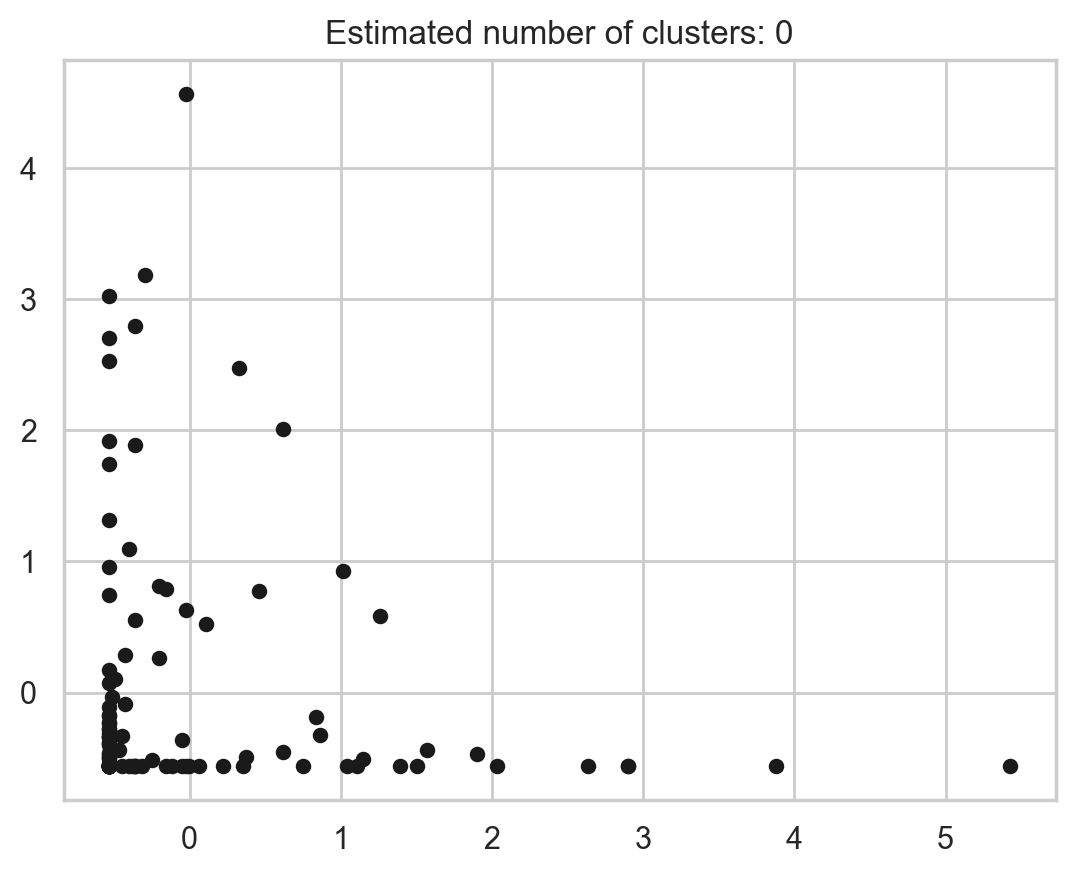

In [65]:
db = DBSCAN(eps=0.2, min_samples=4).fit(X)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

# Cosine Similarity for similar songs

In [67]:
doc_similarity_matrix9 = pd.DataFrame(cosine_similarity(h9))
doc_similarity_matrix9.head(10)

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,1.000000,0.067578,0.120568,0.078070,0.324944,0.078259,0.007546,0.114538,0.920411,0.839261,...,0.163805,0.208352,0.077062,0.314172,0.052143,0.184080,0.098441,0.083365,0.184473,0.091219
1,0.067578,1.000000,0.590689,0.077250,0.334423,0.759932,0.748143,0.159600,0.218510,0.117911,...,0.798091,0.097731,0.243493,0.308886,0.686924,0.502700,0.827846,0.717769,0.047800,0.684215
2,0.120568,0.590689,1.000000,0.191714,0.198480,0.462688,0.267405,0.775929,0.097731,0.417682,...,0.380698,0.186588,0.692198,0.660144,0.163749,0.265142,0.563740,0.460067,0.248164,0.429100
3,0.078070,0.077250,0.191714,1.000000,0.007628,0.012992,0.012943,0.000000,0.030108,0.099427,...,0.192129,0.651009,0.273669,0.773173,0.033871,0.407524,0.185690,0.001177,0.109559,0.065808
4,0.324944,0.334423,0.198480,0.007628,1.000000,0.354325,0.130299,0.012898,0.318935,0.457735,...,0.208900,0.021625,0.014655,0.193537,0.112694,0.471377,0.706228,0.324691,0.370246,0.692572
5,0.078259,0.759932,0.462688,0.012992,0.354325,1.000000,0.171413,0.000000,0.036135,0.002604,...,0.377907,0.020505,0.015915,0.147881,0.113859,0.142482,0.616517,0.991207,0.020535,0.893249
6,0.007546,0.748143,0.267405,0.012943,0.130299,0.171413,1.000000,0.080507,0.313672,0.070052,...,0.861529,0.020427,0.106835,0.179625,0.988365,0.617715,0.569478,0.113525,0.014543,0.133926
7,0.114538,0.159600,0.775929,0.000000,0.012898,0.000000,0.080507,1.000000,0.000000,0.322749,...,0.258627,0.331420,0.635603,0.477157,0.000000,0.023206,0.221462,0.029855,0.598048,0.029210
8,0.920411,0.218510,0.097731,0.030108,0.318935,0.036135,0.313672,0.000000,1.000000,0.830628,...,0.316228,0.008891,0.000000,0.268194,0.368257,0.346675,0.180252,0.019821,0.000000,0.021767
9,0.839261,0.117911,0.417682,0.099427,0.457735,0.002604,0.070052,0.322749,0.830628,1.000000,...,0.071415,0.029360,0.370220,0.459449,0.073841,0.259582,0.271185,0.001428,0.082904,0.090285


In [68]:
doc_similarity_matrix9.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
101,0.163805,0.798091,0.380698,0.192129,0.208900,0.377907,0.861529,0.258627,0.316228,0.071415,...,1.000000,0.389854,0.110053,0.374277,0.851114,0.607576,0.656931,0.343069,0.398537,0.353473
102,0.208352,0.097731,0.186588,0.651009,0.021625,0.020505,0.020427,0.331420,0.008891,0.029360,...,0.389854,1.000000,0.431934,0.574560,0.010002,0.249715,0.225033,0.024048,0.617427,0.125575
103,0.077062,0.243493,0.692198,0.273669,0.014655,0.015915,0.106835,0.635603,0.000000,0.370220,...,0.110053,0.431934,1.000000,0.541604,0.000000,0.144259,0.334552,0.001162,0.112006,0.072788
104,0.314172,0.308886,0.660144,0.773173,0.193537,0.147881,0.179625,0.477157,0.268194,0.459449,...,0.374277,0.574560,0.541604,1.000000,0.143331,0.618252,0.361187,0.114089,0.329132,0.225671
105,0.052143,0.686924,0.163749,0.033871,0.112694,0.113859,0.988365,0.000000,0.368257,0.073841,...,0.851114,0.010002,0.000000,0.143331,1.000000,0.596217,0.513735,0.062454,0.000000,0.068585
106,0.184080,0.502700,0.265142,0.407524,0.471377,0.142482,0.617715,0.023206,0.346675,0.259582,...,0.607576,0.249715,0.144259,0.618252,0.596217,1.000000,0.503062,0.036390,0.215244,0.337450
107,0.098441,0.827846,0.563740,0.185690,0.706228,0.616517,0.569478,0.221462,0.180252,0.271185,...,0.656931,0.225033,0.334552,0.361187,0.513735,0.503062,1.000000,0.592897,0.287081,0.763717
108,0.083365,0.717769,0.460067,0.001177,0.324691,0.991207,0.113525,0.029855,0.019821,0.001428,...,0.343069,0.024048,0.001162,0.114089,0.062454,0.036390,0.592897,1.000000,0.040508,0.866346
109,0.184473,0.047800,0.248164,0.109559,0.370246,0.020535,0.014543,0.598048,0.000000,0.082904,...,0.398537,0.617427,0.112006,0.329132,0.000000,0.215244,0.287081,0.040508,1.000000,0.249025
110,0.091219,0.684215,0.429100,0.065808,0.692572,0.893249,0.133926,0.029210,0.021767,0.090285,...,0.353473,0.125575,0.072788,0.225671,0.068585,0.337450,0.763717,0.866346,0.249025,1.000000


In [69]:
doc_similarity_matrix9[0][1].round(4)

0.0676

In [70]:
0.068
doc_similarity_matrix9[0].nlargest(5)

0      1.000000
75     0.981346
38     0.976596
91     0.946970
100    0.935144
Name: 0, dtype: float64

In [71]:
doc_similarity_matrix9[5].nlargest(5)

5      1.000000
50     0.993349
108    0.991207
57     0.983566
53     0.976899
Name: 5, dtype: float64

In [75]:
df.track_title[5],df.track_title[50]

('The Outside', 'I Almost Do')

In [76]:
doc_similarity_matrix9[1].nlargest(5)

1     1.000000
79    0.985186
22    0.946767
18    0.902269
19    0.884919
Name: 1, dtype: float64

In [77]:
df.track_title[1],df.track_title[79],df.track_title[22]

('Picture To Burn', '...Ready for It?', 'Youre Not Sorry')

In [78]:
df.track_lyric[1]

'state the obvious  i didn t get my perfect fantasy i realize you love yourself more than you could ever love me so go and tell your friends that i m obsessive and crazy that s fine  i ll tell mine that you re gay by the way i hate that stupid old pickup truck you never let me drive you re a redneck heartbreak who s really bad at lying so watch me strike a match on all my wasted time as far as i m concerned you re just another picture to burn there s no time for tears i m just sitting here planning my revenge there s nothing stopping me from going out with all of your best friends and if you come around saying sorry to me my daddy s gonna show you how sorry you ll be i hate that stupid old pickup truck you never let me drive you re a redneck heartbreak who s really bad at lying so watch me strike a match on all my wasted time as far as i m concerned you re just another picture to burn and if you re missing me you d better keep it to yourself  cause coming back around here would be bad 

# Modeling Classifiers

In [79]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

In [80]:
X = FeatureSet.loc[:,'danceability':'duration_ms'].drop(columns=['loudness','mode'])
y = FeatureSet.loc[:,'genre_broad']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

# Decision Tree

0.625

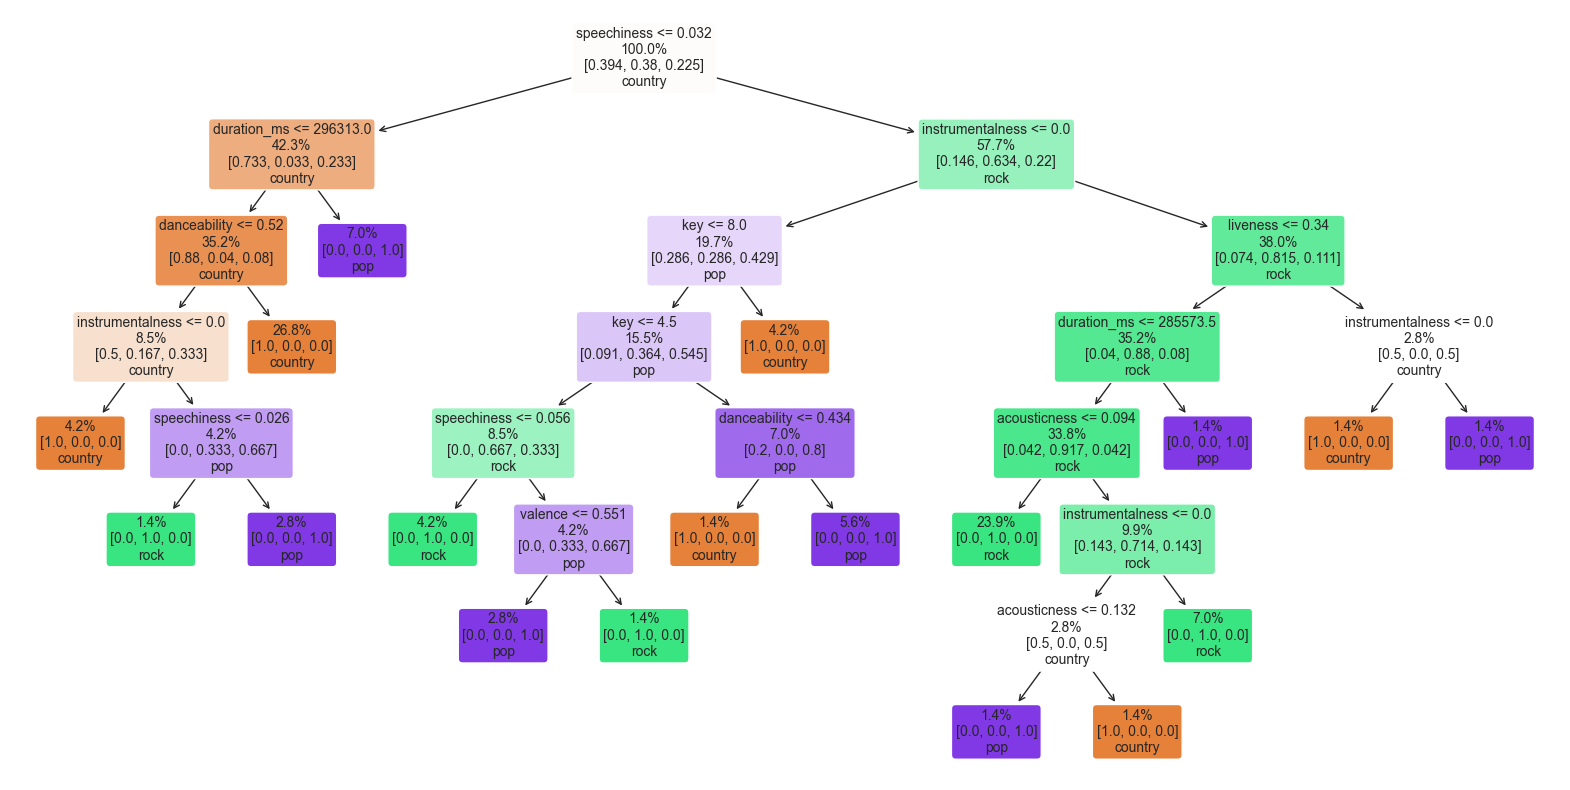

In [85]:
dt = DecisionTreeClassifier(min_samples_leaf=1)
dt.fit(X_train, y_train)

fig = plt.figure(figsize=(20,10))
#tree.plot_tree(dt);

a = plot_tree(dt, 
              feature_names=X.columns, 
              class_names=y.unique(), 
              label={"root"},
              proportion=True,
              filled=True, 
              impurity=False,
              rounded=True, 
              fontsize=10)

yhat=dt.predict(X_test)
dt.score(X_test,y_test)

# Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)




0.7083333333333334

# Naive Bayes

In [90]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(gnb.score(X_test, y_test))

mnb = MultinomialNB(alpha=1000)
print((mnb.fit(X_train, y_train)).score(X_test, y_test))

0.5416666666666666
0.4166666666666667


# Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.4166666666666667